In [2]:
from keras.layers import LSTM
from keras.models import Sequential, load_model

from timeseries_ml_utils.data import *
from timeseries_ml_utils.statistics import *
from timeseries_ml_utils.encoders import *

import matplotlib.pyplot as plt

# encoders and decoders
linreg = RegressionLine(16)

# fetch data
#data = DataFetcher(["GLD.US"], limit=350)  # 550
data = DataFetcher(["GLD.US"])

print(data.fetch_data().tail())
print(len(data.get_dataframe()))


Using TensorFlow backend.


            GLD.US.Open  GLD.US.High  GLD.US.Low  GLD.US.Close  GLD.US.Volume
Date                                                                         
2018-12-11       117.67       117.89     117.350        117.54        6395391
2018-12-12       117.70       117.95     117.612        117.79        4136781
2018-12-13       117.54       117.62     117.260        117.53        4131770
2018-12-14       116.63       117.30     116.580        117.06        7501660
2018-12-17       117.37       118.03     117.350        117.87        8455007
2254


In [5]:
def regression_encode_decode(y, ref, encode):
    if encode:
        x = np.arange(0, len(y))
        y = normalize(y, ref, True)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        return np.array([intercept + slope * i for i in range(len(y))])
    else:
        return normalize(y, ref, False)


In [6]:
model_data = DataGenerator(data.get_dataframe(), 
                           {"^trigonometric": identity, 
                            "(Open|High|Low|Close)$": normalize}, 
                           {"GLD.US.Close$": regression_encode_decode},
                           aggregation_window_size=16, batch_size=10, 
                           training_percentage=0.8, 
                           model_path="/tmp/keras-regression-line-price-1")
print(model_data.get_df_columns())
print("feature shape:", model_data.batch_feature_shape)
print("labels shape:", model_data.batch_label_shape)
print("train/test data:", len(model_data), len(model_data.as_test_data_generator()))
print("max batch size:", model_data.get_max_batch_size())
model_data.features, model_data.labels


['GLD.US.Open', 'GLD.US.High', 'GLD.US.Low', 'GLD.US.Close', 'GLD.US.Volume', 'GLD.US.Open_variance', 'GLD.US.High_variance', 'GLD.US.Low_variance', 'GLD.US.Close_variance', 'GLD.US.Volume_variance', 'trigonometric_time.cos_dow', 'trigonometric_time.sin_dow', 'trigonometric_time.cos_woy', 'trigonometric_time.sin_woy', 'trigonometric_time.cos_doy', 'trigonometric_time.sin_doy', 'trigonometric_time.sin_yer', 'trigonometric_time.cos_yer', 'trigonometric_time.sin_dec', 'trigonometric_time.cos_dec']
feature shape: (10, 260, 224)
labels shape: (10, 16)
train/test data: 1564 391
max batch size: 391


([('GLD.US.Open', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.High', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.Low', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.Close', <function timeseries_ml_utils.encoders.normalize>),
  ('trigonometric_time.cos_dow',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_dow',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_woy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_woy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_doy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_doy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_yer',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_yer',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.s

In [7]:

model = Sequential(name="LSTM-Model-1")
model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-1",
               batch_input_shape=model_data.batch_feature_shape,
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=True))

model.add(LSTM(model_data.batch_label_shape[-1] * 2,
               name="LSTM-Layer-2",
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=True))

model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-3",
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse", metrics=['mae', 'acc'])

train_args = {"epochs": 1,
              "use_multiprocessing": True,
              "workers": 4,
              "shuffle": False,
              "verbose": 1}

fit = model_data.fit(model, train_args, frequency=10, relative_accuracy_function=r_square)
print("done")

Epoch 1/1
1564/1564 [==============================] - 642s 411ms/step - loss: 7.7446e-04 - mean_absolute_error: 0.0209 - acc: 0.1328 - val_loss: 3.2257e-04 - val_mean_absolute_error: 0.0141 - val_acc: 0.2251

done


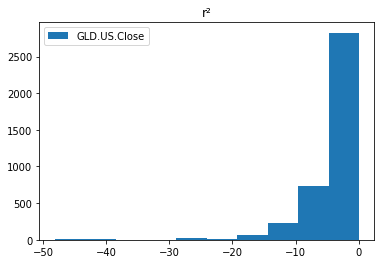

In [6]:
back_test = fit.back_test_history
back_test.plot_hist()

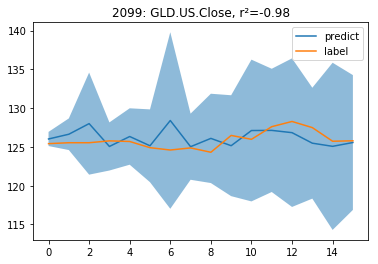

In [26]:
back_test.plot_random_sample()

In [4]:
#restored = PredictiveDataGenerator("/home/kic/Documents/keras/keras-regression-line-price-1", data.get_dataframe())
restored = PredictiveDataGenerator("/tmp/keras-regression-line-price-1", data.get_dataframe())


IndexError: list index out of range

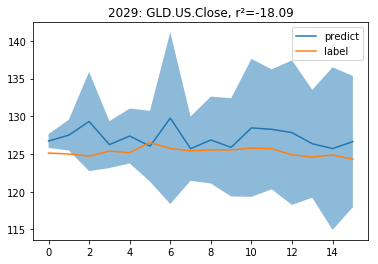

In [48]:
restored.back_test_history.plot_random_sample()